In [1]:
#This is for analyzing layer data 

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
import yaspy
import scipy
import pyvista as pv
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
import brainspace.gradient.alignment as ga

pv.start_xvfb()

radii = [6]  # 0 means raw data
normalize_data = False #normalize at raw data level 


#schaefer
atlas_path = '/Users/dennis.jungchildmind.org/Downloads/Schaefer2018_100Parcels_17Networks_order.dlabel.nii'
atlas = nib.load(atlas_path).get_fdata()[0].astype(int)
num_parcels = int(atlas_path.split('_')[1].split('Parcels')[0])  # Extract number of parcels from atlas path
print(num_parcels)



#glasser
'''
atlas_path_R = '/Users/dennis.jungchildmind.org/Downloads/Glasser_2016.32k.R.label.gii'
atlas_R = nib.load(atlas_path_R).darrays[0].data
atlas_path_L = '/Users/dennis.jungchildmind.org/Downloads/Glasser_2016.32k.L.label.gii'
atlas_L = nib.load(atlas_path_L).darrays[0].data
atlas = np.concatenate([atlas_L, atlas_R])
'''

#Desikan
'''
atlas_path_R = '/Users/dennis.jungchildmind.org/Downloads/Desikan.32k.R.label.gii'
atlas_R = nib.load(atlas_path_R).darrays[0].data
atlas_path_L = '/Users/dennis.jungchildmind.org/Downloads/Desikan.32k.L.label.gii'
atlas_L = nib.load(atlas_path_L).darrays[0].data
atlas = np.concatenate([atlas_L, atlas_R])
'''


#I think I should use something with less parcellation
#atlas_path = '/Users/dennis.jungchildmind.org/Downloads/Glasser_2016.32k.R.label.gii'
#In each subject folder (N = 17), there are preprocessed databy Zixuan
# Per his description, I can use the 32k_fs_LR files (if higher resolution is needed use 164k_fs_LR files)
# order of the "boundary" between the layers is the "pial", 'inf (according to the paper, boundary between layer 1-3 (supragranular layer) and layer 4-6, says infragranular though the layer 4 is not infragranular technically)", and "white (for white matter)"
# for each subject, there is either left or right hemisphere, or both hemispheres
layers = ['pial','inf','white']

baseDir = '/Users/dennis.jungchildmind.org/Downloads/exvivo/'

#for hcp
#baseDir = '/Users/dennis.jungchildmind.org/OneDrive - Child Mind Institute/hcp1200/HCP1200/'
# Get all subdirectories in baseDir

subject_dirs = [d for d in os.listdir(baseDir) if os.path.isdir(os.path.join(baseDir, d))]

# Dictionary to store data for each subject
subject_data = {}


/opt/anaconda3/envs/niwrap3912/lib/python3.11/site-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


100


In [2]:
from sklearn.covariance import LedoitWolf, OAS, GraphicalLasso

 
def improved_partial_correlation_with_shrinkage(x):
    """
    Partial correlation with Ledoit-Wolf shrinkage applied consistently
    x: (n_features, n_samples) 
    Returns: (n_features, n_features) partial correlation matrix
    """
  
    n_features, n_samples = x.shape
    
    # Step 1: Handle NaN values
    x_clean = x.copy()
    for i in range(n_features):
        mask = np.isnan(x_clean[i, :])
        if mask.any():
            x_clean[i, mask] = np.nanmean(x_clean[i, :])
    
    # Step 2: Calculate mean across features for each sample
    x_mean = np.mean(x_clean, axis=0)  # Shape: (n_samples,)
    
    # Step 3: Create augmented data matrix
    # Transpose for sklearn: samples x features
    augmented_data = np.column_stack([x_clean.T, x_mean])  # Shape: (n_samples, n_features+1)
    
    # Step 4: Apply Ledoit-Wolf shrinkage
    lw = LedoitWolf()
    shrunk_cov = lw.fit(augmented_data).covariance_  # Shape: (n_features+1, n_features+1)
    #oa = OAS()
    #shrunk_cov = oa.fit(augmented_data).covariance_  # Shape: (n_features+1, n_features+1)
    # Convert to correlation matrix
    def cov_to_corr(cov):
        std = np.sqrt(np.diag(cov))
        return cov / np.outer(std, std)
    
    shrunk_corr = cov_to_corr(shrunk_cov)  # Shape: (n_features+1, n_features+1)
    
    # Step 5: Extract components for partial correlation
    r_ij = shrunk_corr[:n_features, :n_features]  # Shape: (n_features, n_features)
    r_ic = shrunk_corr[:n_features, -1]           # Shape: (n_features,)
    
    # Step 6: Calculate partial correlations
    r_icjc = np.outer(r_ic, r_ic)  # Shape: (n_features, n_features)
    denominator = np.sqrt(np.outer((1 - r_ic**2), (1 - r_ic**2)))  # Shape: (n_features, n_features)
    
    # Avoid division by zero
    denominator[denominator < np.finfo(float).eps] = np.finfo(float).eps
    
    partial_corr = (r_ij - r_icjc) / denominator  # Shape: (n_features, n_features)
    
    # Step 7: Clean up the matrix
    np.fill_diagonal(partial_corr, 0)
    partial_corr[np.isnan(partial_corr) | np.isinf(partial_corr)] = 0
    partial_corr = np.clip(partial_corr, -1, 1)
    
    return partial_corr  # Shape: (n_features, n_features) 

def calculate_partial_correlations(x):
    """
    Calculate partial correlations between regions while controlling for mean thickness.
    
    Parameters:
    -----------
    x : numpy.ndarray
        Input data matrix with shape (n_regions, n_samples)
        
    Returns:
    --------
    partial_corr : numpy.ndarray
        Matrix of partial correlations between regions
    """
    # First get pairwise correlations between regions
    
    r_ij = np.corrcoef(x)
    # Calculate mean thickness across regions
    x_mean = np.nanmean(x, axis=0)
    # Get correlations between each region and the mean
    r_ic = np.corrcoef(x, x_mean[np.newaxis,:])[-1,:-1]
    
    # Calculate partial correlations controlling for mean
    # Formula: (r_ij - r_i,m * r_j,m) / sqrt((1-r_i,m^2)(1-r_j,m^2))
    # where r_i,m is correlation of region i with mean
    r_icjc = np.outer(r_ic, r_ic)
    partial_corr = (r_ij - r_icjc) / np.sqrt(np.outer((1-r_ic**2), (1-r_ic**2)))


    # zero out correlations of 1 (to avoid division by 0)
    partial_corr[np.isclose(partial_corr, 1)] = 0
    # Fisher z-transform the correlations
    #partial_corr = 0.5 * np.log((1 + partial_corr) / (1 - partial_corr))

    # Clean up any invalid values
    partial_corr[np.isnan(partial_corr) | np.isinf(partial_corr)] = 0
    
    return partial_corr


def calculate_correlation_matrix(data, transpose, partial_corr, shrink_it, first_index):
    """Calculate correlation matrix based on given parameters."""
    if transpose:
        data = data[first_index:].T
    else:
        data = data[first_index:]
        
    if partial_corr:
        corr = calculate_partial_correlations(data)
        if shrink_it:
            print('shrinkage')
            corr = improved_partial_correlation_with_shrinkage(data)
    else:
        corr = np.corrcoef(data)
        
    return corr

def plot_correlation_matrix(corr, transpose, title, radius):
    """Plot correlation matrix with consistent formatting."""
    # Remove diagonal values
    corr_plot = corr.copy()
    corr_plot[np.eye(corr_plot.shape[0], dtype=bool)] = np.nan
    
    # Plot matrix
    if transpose:
        im = plt.imshow(corr_plot, cmap='jet', vmin=0, vmax=1)
    else:
        im = plt.imshow(corr_plot, cmap='bwr')
        
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(f'{title}\nRadius {radius}mm')
    plt.xlabel('Subject')
    plt.ylabel('Subject')
    
    return corr

def plot_subject_similarity(hemisphere_data, radii, transpose=False, partial_corr=False, shrink_it=False):
    """
    Plot similarity matrices between subjects for different thickness measures and radii.
    
    Args:
        hemisphere_data (dict): Dictionary containing thickness data for one hemisphere
        radii (list): List of radius values used for smoothing
        transpose (bool): Whether to transpose the data matrices
        partial_corr (bool): Whether to calculate partial correlations
        shrink_it (bool): Whether to apply shrinkage to correlation calculation
    """
    # Initialize correlation dictionaries
    correlation_dicts = {
        'total': {},
        'infra': {},
        'supra': {},
        'relative': {},
        'ratio': {}
    }

    first_index = 1
    plt.figure(figsize=(len(correlation_dicts)*4,len(radii)*4))

    # Plot matrices for each radius
    for i, radius in enumerate(radii):
        # Define measures and their plot positions 
        measures = [
            ('total', 'Total Thickness', i+1),
            ('infra', 'WM to Inf Thickness', i+1+1),
            ('supra', 'Inf to Pial Thickness', i+1+2),
            ('relative', 'Relative Thickness', i+1+3),
            ('ratio', 'ratio Thickness', i+1+4)
        ]
        
        # Plot each measure
        for measure, title, plot_pos in measures:
            print(len(radii), len(measures), plot_pos)
            plt.subplot(len(radii), len(measures), plot_pos)
            
            # Calculate correlation matrix
            corr = calculate_correlation_matrix(
                hemisphere_data[measure][i],
                transpose,
                partial_corr,
                shrink_it,
                first_index
            )
            
            # Store and plot correlation matrix
            correlation_dicts[measure][i] = plot_correlation_matrix(
                corr,
                transpose,
                title,
                radius
            )

    plt.tight_layout()
    
    return tuple(correlation_dicts[k] for k in ['total', 'infra', 'supra', 'relative', 'ratio'])



def parcellate_data(matrix, atlas, hemisphere):
    """Parcellate cortical layer data using a given atlas."""
    # Load atlas
    parcelIndices = atlas
    max_parcel_ind = int(np.max(parcelIndices))
    
   
    if max_parcel_ind == 100 or max_parcel_ind == 200 or max_parcel_ind == 400 or max_parcel_ind == 1000:
        #if Schaefer parcellation
        m = int(max_parcel_ind/2)+1
    elif max_parcel_ind == 180:
        #if Glasser parcellation
        m = 180 + 1
    elif max_parcel_ind == 35:
        #if Desikan parcellation
        m = 35 + 1
    else: 
        raise ValueError(f"Unsupported parcellation with {max_parcel_ind} parcels")
        
    # Split indices by hemisphere
    if hemisphere == 'lh':
        parcelIndices = parcelIndices[0:32492]
    elif hemisphere == 'rh':
        parcelIndices = parcelIndices[32492:]
    
    # Initialize output array
    parcellated = []
    
    # Parcellate data for each subject
    for subject_idx in range(matrix.shape[0]):
        
        #m = int(max_parcel_ind/2)+1
        #m = 180+1 #for glasser or deikan (35)
       # m = 35+1;#desikan
        # Initialize array for this hemisphere's parcels
        subject_data = np.zeros(m)
        
        # Get subject's data
        data = matrix[subject_idx]
        
        # Set parcel range based on hemisphere
        if hemisphere == 'lh':
            parcel_range = range(0, m)
            print(parcel_range)
        elif hemisphere == 'rh':
            parcel_range = list(range(m, max_parcel_ind+1))
            parcel_range.insert(0, 0)
            print(parcel_range)

            if max_parcel_ind == 180 or max_parcel_ind == 35:
                parcel_range = range(1,m) #for glasser or deikan
            
            
        # Calculate mean for each parcel
        for k in parcel_range:
            mask = parcelIndices == k
            if np.sum(mask) > 0:
                
                if max_parcel_ind == 180 or max_parcel_ind == 35:
                    parcel_idx = k #parcel_idx = k  #for glasser or deikan
                else:
                    parcel_idx = k if hemisphere == 'lh' else k-m+1
                
                #instead of trimmed mean, calculates mean and standard deviation and remove anything above 2 standard deviations
                mean = np.mean(data[mask][~np.isnan(data[mask])])
                std = np.std(data[mask][~np.isnan(data[mask])])
                subject_data[parcel_idx] = np.mean(data[mask][data[mask] < mean + 1.5*std])
                
                # This uses trimmed mean with 10% trim on both ends
                # Science advances paper, "structural covariance, Parcellation Approach in Methods"
                #subject_data[parcel_idx] = scipy.stats.trim_mean(data[mask][~np.isnan(data[mask])], proportiontocut=0.1)
                
                
        # Append subject's parcellated data
        parcellated.append(subject_data)
            
    # Convert list to numpy array
    return np.vstack(parcellated)


In [3]:

data_types = ['infra', 'supra', 'relative', 'ratio', 'total']
hemispheres = {'lh': 'left', 'rh': 'right'}


# Initialize dictionaries
data = {hemi: {dtype: [[] for _ in radii] for dtype in data_types} for hemi in hemispheres}

for subjectDir in subject_dirs:
    print(subjectDir)
    
    for i, radius in enumerate(radii):
        print(i)
        
        for hemi in hemispheres:
            if os.path.exists(f'{baseDir}{subjectDir}/{hemi}.pial.32k_fs_LR.surf.gii'):
                # Load thickness data
                if radius == 0:
                    # For raw data, use original thickness
                    suffix = '32k_fs_LR'
                else:
                    suffix = f'32k_{radius}mm_fwhm_fs_LR'
                
                thickness_data = {
                    'infra': nib.load(f'{baseDir}{subjectDir}/{hemi}.thickness.wm.inf.{suffix}.shape.gii').darrays[0].data,
                    'supra': nib.load(f'{baseDir}{subjectDir}/{hemi}.thickness.inf.pial.{suffix}.shape.gii').darrays[0].data,
                    'total': nib.load(f'{baseDir}{subjectDir}/{hemi}.thickness.{suffix}.shape.gii').darrays[0].data
                }
                thickness_data['relative'] = thickness_data['supra'] / thickness_data['infra']
                #set thickness_data['relative'] to 0 if it is nan
                thickness_data['relative'][np.isnan(thickness_data['relative'])] = 0
                thickness_data['relative'][np.isinf(thickness_data['relative'])] = 0

                #for ratio (which is total infragranular layer over total thickness)
                thickness_data['ratio'] = thickness_data['supra'] / thickness_data['total']
                thickness_data['ratio'][np.isnan(thickness_data['ratio'])] = 0
                thickness_data['ratio'][np.isinf(thickness_data['ratio'])] = 0

                if normalize_data:
                    #calculate relative thickness first before calculating other stuff
                    nonzero_relative = thickness_data['relative'][thickness_data['relative'] != 0]
                    thickness_data['relative'] = (thickness_data['relative'] - np.mean(nonzero_relative)) / np.std(nonzero_relative)
                    #ratio
                    nonzero_ratio = thickness_data['ratio'][thickness_data['ratio'] != 0]
                    thickness_data['ratio'] = (thickness_data['ratio'] - np.mean(nonzero_ratio)) / np.std(nonzero_ratio)
                    #then calculate infra, supra, and total
                    nonzero_infra = thickness_data['infra'][thickness_data['infra'] != 0]
                    thickness_data['infra'] = (thickness_data['infra'] - np.mean(nonzero_infra)) / np.std(nonzero_infra)
                    nonzero_supra = thickness_data['supra'][thickness_data['supra'] != 0]
                    thickness_data['supra'] = (thickness_data['supra'] - np.mean(nonzero_supra)) / np.std(nonzero_supra)
                    nonzero_total = thickness_data['total'][thickness_data['total'] != 0]
                    thickness_data['total'] = (thickness_data['total'] - np.mean(nonzero_total)) / np.std(nonzero_total)
                
                # Process each data type
                for dtype in data_types:
                    reshaped_data = thickness_data[dtype].reshape(-1, 1)
                    if len(data[hemi][dtype][i]) == 0:
                        data[hemi][dtype][i] = reshaped_data
                    else:
                        data[hemi][dtype][i] = np.concatenate((data[hemi][dtype][i], reshaped_data), axis=1)
                
                # Clean up relative thickness data
                data[hemi]['relative'][i][np.isnan(data[hemi]['relative'][i])] = 0
                data[hemi]['relative'][i][np.isinf(data[hemi]['relative'][i])] = 0

# Rename variables to match rest of code
lh_data = data['lh']
rh_data = data['rh']

I57_new_confidence
0
I58_new_confidence
0
I45_new_confidence
0
I59_new_confidence
0
I56_new_confidence
0
I41_new_confidence
0
I54_new_confidence
0
I38_new_confidence
0
I53_new_confidence
0
I46_new_confidence
0
EXC022_new_confidence
0
I52_new_confidence
0
I48_new_confidence
0
I55_new_confidence
0
I61_new_confidence
0
KC001_new_confidence
0
I60_new_confidence
0


/var/folders/71/4g31r9017kq32wt_mx1khjdm0000gn/T/ipykernel_4772/2559182410.py:28: RuntimeWarning: divide by zero encountered in divide
  thickness_data['relative'] = thickness_data['supra'] / thickness_data['infra']
/var/folders/71/4g31r9017kq32wt_mx1khjdm0000gn/T/ipykernel_4772/2559182410.py:28: RuntimeWarning: invalid value encountered in divide
  thickness_data['relative'] = thickness_data['supra'] / thickness_data['infra']
/var/folders/71/4g31r9017kq32wt_mx1khjdm0000gn/T/ipykernel_4772/2559182410.py:34: RuntimeWarning: invalid value encountered in divide
  thickness_data['ratio'] = thickness_data['supra'] / thickness_data['total']


1 5 1
1 5 2
1 5 3
1 5 4
1 5 5
1 5 1
1 5 2
1 5 3
1 5 4
1 5 5


({0: array([[1.        , 0.84778101, 0.88935316, 0.87530164, 0.89977193,
          0.84957729, 0.89471797],
         [0.84778101, 1.        , 0.8282607 , 0.84197901, 0.858416  ,
          0.84260291, 0.86115167],
         [0.88935316, 0.8282607 , 1.        , 0.85555731, 0.88897928,
          0.81823231, 0.88749256],
         [0.87530164, 0.84197901, 0.85555731, 1.        , 0.89065611,
          0.82433065, 0.87821493],
         [0.89977193, 0.858416  , 0.88897928, 0.89065611, 1.        ,
          0.85181934, 0.90762922],
         [0.84957729, 0.84260291, 0.81823231, 0.82433065, 0.85181934,
          1.        , 0.84988685],
         [0.89471797, 0.86115167, 0.88749256, 0.87821493, 0.90762922,
          0.84988685, 1.        ]])},
 {0: array([[1.        , 0.80233004, 0.84462074, 0.83530943, 0.85361712,
          0.76725023, 0.83051039],
         [0.80233004, 1.        , 0.78425003, 0.823953  , 0.81365542,
          0.77476798, 0.80002194],
         [0.84462074, 0.78425003, 1.        , 

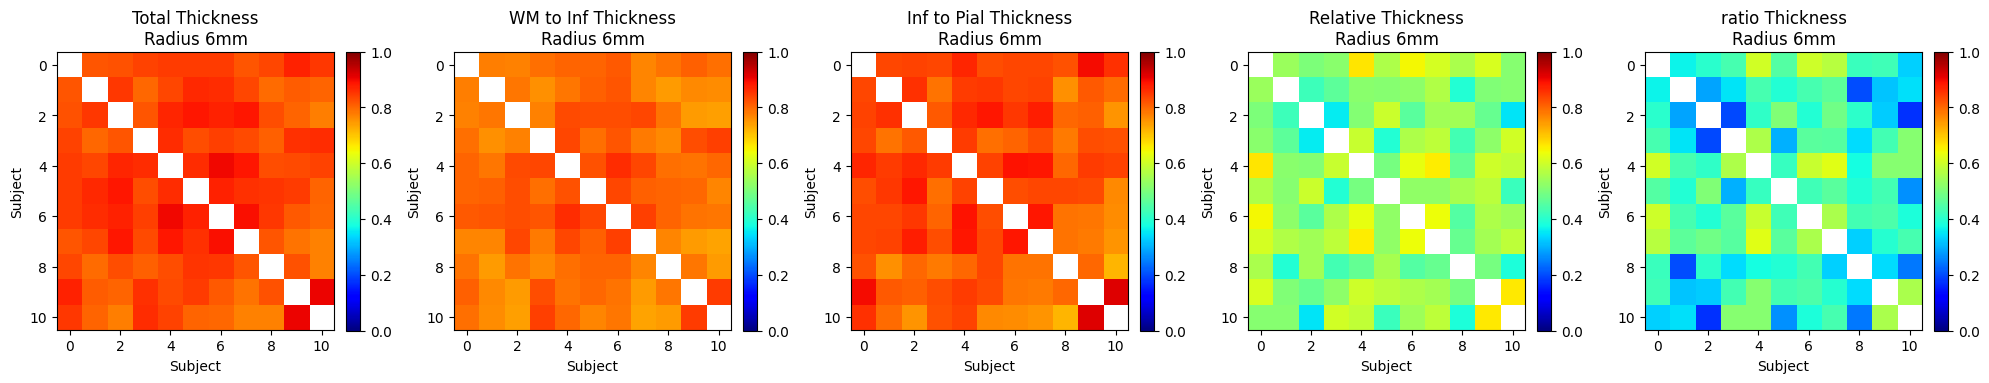

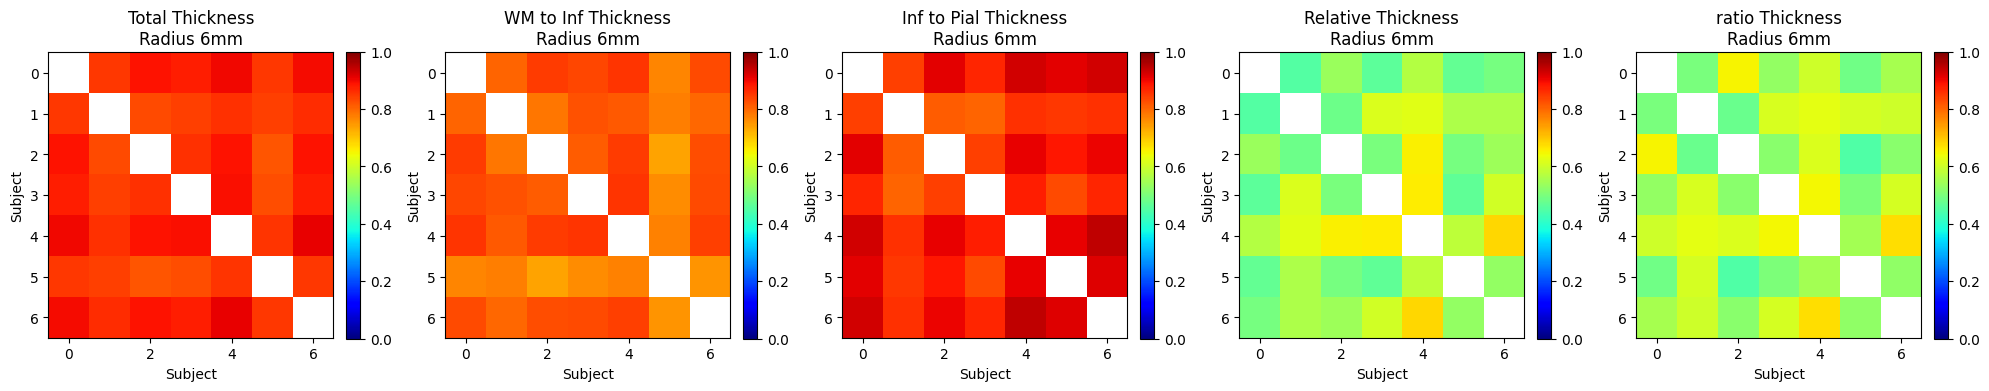

In [4]:

plot_subject_similarity(lh_data, radii, transpose=True, partial_corr=False)
plot_subject_similarity(rh_data, radii, transpose=True, partial_corr=False)

In [5]:
lh_data

{'infra': [array([[1.2921375 , 1.170814  , 1.1795795 , ..., 1.1580521 , 1.3368294 ,
          1.3735127 ],
         [1.3431422 , 1.0711212 , 0.9894311 , ..., 1.2603219 , 1.0656114 ,
          0.9884332 ],
         [1.5496565 , 1.551762  , 1.5555753 , ..., 1.5941104 , 1.4697932 ,
          1.7189304 ],
         ...,
         [1.2130789 , 0.96659404, 1.1189561 , ..., 1.1078924 , 0.9747682 ,
          1.1717871 ],
         [1.153726  , 1.0521659 , 1.1571938 , ..., 1.0608125 , 1.0533867 ,
          1.1283855 ],
         [1.0617487 , 0.9839212 , 1.0814719 , ..., 1.0472186 , 0.9966124 ,
          1.1258373 ]], shape=(32492, 11), dtype=float32)],
 'supra': [array([[0.95041794, 0.95700157, 1.0563861 , ..., 1.1331977 , 0.9652139 ,
          1.051231  ],
         [0.9919298 , 0.9560722 , 1.0869044 , ..., 1.1841105 , 1.0229483 ,
          1.0823355 ],
         [0.93058735, 1.0251513 , 1.1080334 , ..., 1.001787  , 0.9921521 ,
          1.0941863 ],
         ...,
         [0.95229226, 0.9846884 , 1

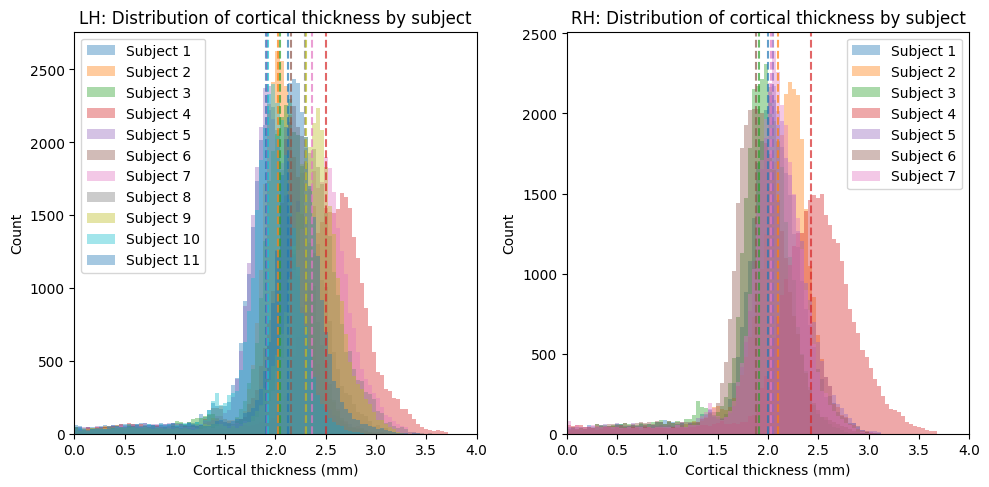

In [6]:
# Create histograms for smoothed data from both hemispheres for each subject
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))

layer_type = 'total'

if layer_type == 'total':
    xlimit = (0,1) if normalize_data else (0,4)
    xlabel = 'Cortical thickness (mm)'
    title = 'Distribution of cortical thickness by subject'
elif layer_type == 'relative':
    xlimit = (0,1) if normalize_data else (0,3)
    xlabel = 'Relative cortical thickness'
    title = 'Distribution of relative cortical thickness by subject'
elif layer_type == 'infra' or layer_type == 'supra':
    xlimit = (0,2) if normalize_data else (0,2)
    xlabel = 'Cortical thickness (mm)'
    title = 'Distribution of cortical thickness by subject'
elif layer_type == 'proportional':
    xlimit = (0,1)
    xlabel = 'Proportional cortical thickness'
    title = 'Distribution of proportional cortical thickness by subject'

# Transpose data to get shape (11, 32491) so each row is a subject
lh_data_by_subject = lh_data[layer_type][0].T
rh_data_by_subject = rh_data[layer_type][0].T

# Plot histogram for each subject for left hemisphere
for i in range(lh_data_by_subject.shape[0]):
    # Remove zeros from the data
    non_zero_data = lh_data_by_subject[i][lh_data_by_subject[i] != 0]
    hist = ax1.hist(non_zero_data, bins=100, range=xlimit, alpha=0.4, label=f'Subject {i+1}')
    # Add vertical line for mean using the color of the last histogram
    mean = np.mean(non_zero_data)
    ax1.axvline(x=mean, color=hist[2][0].get_facecolor(), linestyle='--', alpha=0.7)

ax1.set_xlabel('Cortical thickness (mm)')
ax1.set_ylabel('Count')
ax1.set_title('LH: Distribution of cortical thickness by subject')
ax1.legend()
ax1.set_xlim(xlimit)

# Plot histogram for each subject for right hemisphere
for i in range(rh_data_by_subject.shape[0]):
    # Remove zeros from the data
    non_zero_data = rh_data_by_subject[i][rh_data_by_subject[i] != 0]
    hist = ax2.hist(non_zero_data, bins=100, range=xlimit, alpha=0.4, label=f'Subject {i+1}')
    # Add vertical line for mean using the color of the last histogram
    mean = np.mean(non_zero_data)
    ax2.axvline(x=mean, color=hist[2][0].get_facecolor(), linestyle='--', alpha=0.7)

ax2.set_xlabel('Cortical thickness (mm)')
ax2.set_ylabel('Count')
ax2.set_title('RH: Distribution of cortical thickness by subject')
ax2.legend()
ax2.set_xlim(xlimit)


# Make plots square by setting aspect ratio
ax1.set_aspect(1.0/ax1.get_data_ratio())
ax2.set_aspect(1.0/ax2.get_data_ratio())

plt.tight_layout()
plt.show()

In [7]:
def process_hemisphere_data(data, atlas, hemi):
    """
    Process hemisphere data by parcellating metrics and calculating derived measures
    
    Parameters:
    -----------
    data : dict
        Dictionary containing hemisphere data with metrics like 'total', 'infra', etc
    atlas : array-like
        Atlas data for parcellation
    hemi: str, 'lh' or 'rh'
    Returns:
    --------
    dict : Processed and parcellated data
    """
    # Initialize output dictionary
    data_parc = {
        'total': [], 'infra': [], 'supra': [], 'relative': [], 'ratio': []
    }

    # Parcellate basic metrics
    for metric in ['total', 'infra', 'supra']:
        data_parc[metric] = parcellate_data(data[metric].T, atlas, hemi).T
        

    # Calculate relative and ratio metrics
    data_parc['relative'] = data_parc['supra'] / data_parc['infra']
    data_parc['ratio'] = data_parc['supra'] / data_parc['total']

    # Clean up invalid values
    for metric in ['relative', 'ratio']:
        data_parc[metric][data_parc[metric] == np.inf] = 0
        data_parc[metric][data_parc[metric] == np.nan] = 0

    return data_parc



def process_hemisphere_parcellation(lh_data_parc, rh_data_parc, atlas):
    """
    Process left and right hemisphere parcellation data using an atlas
    
    Parameters:
    -----------
    lh_data_parc : dict
        Left hemisphere parcellation data
    rh_data_parc : dict 
        Right hemisphere parcellation data
    atlas : array-like
        Atlas data for mapping
        
    Returns:
    --------
    tuple : Processed left and right hemisphere data
    """
    # Process left hemisphere data
    for key in lh_data_parc.keys():
        mask_lh = atlas[:32492] != 0
        min_atlas = np.min(atlas[:32492][atlas[:32492] != 0])
        max_atlas = np.max(atlas[:32492][atlas[:32492] != 0])
        lh_data_parc[key] = map_to_labels(lh_data_parc[key].ravel()[1:], atlas[:32492], 
                                         mask=mask_lh, fill=np.nan,
                                         source_lab=np.arange(min_atlas, max_atlas+1))
 
        
    # Process right hemisphere data 
    for key in rh_data_parc.keys():
        mask_rh = atlas[32492:] != 0
        min_atlas = np.min(atlas[32492:][atlas[32492:] != 0])
        max_atlas = np.max(atlas[32492:][atlas[32492:] != 0])
        rh_data_parc[key] = map_to_labels(rh_data_parc[key].ravel()[1:], atlas[32492:],
                                         mask=mask_rh, fill=np.nan,
                                         source_lab=np.arange(min_atlas, max_atlas+1))
    
    

    return lh_data_parc, rh_data_parc





def combine_hemispheres_data(lh_data_parc, rh_data_parc):
    """
    Combine left and right hemisphere data into grouped dictionaries and fill NaN values with means
    
    Parameters:
    -----------
    lh_data_parc : dict
        Left hemisphere parcellation data
    rh_data_parc : dict
        Right hemisphere parcellation data
        
    Returns:
    --------
    tuple : Three dictionaries containing grouped layer data:
            - layer_group_parc: Combined supra/gra/infra/total thickness data
            - layer_ind_parc: Individual layer (L1-L6) thickness data  
            - layer_extra_parc: Relative and ratio thickness metrics
    """
    # Combine hemisphere data into groups
    layer_group_parc = {
        'supra': {'lh': lh_data_parc['supra'], 'rh': rh_data_parc['supra']},
        'infra': {'lh': lh_data_parc['infra'], 'rh': rh_data_parc['infra']},
        'total': {'lh': lh_data_parc['total'], 'rh': rh_data_parc['total']},
    }

    layer_extra_parc = {
       # 'relative': {'lh': lh_data_parc['relative'], 'rh': rh_data_parc['relative']},
        'ratio': {'lh': lh_data_parc['ratio'], 'rh': rh_data_parc['ratio']},
    }

    # Fill NaN values with means
    for key in layer_group_parc.keys():
        for hemi in ['lh', 'rh']:
            layer_group_parc[key][hemi][np.isnan(layer_group_parc[key][hemi])] = np.mean(layer_group_parc[key][hemi][~np.isnan(layer_group_parc[key][hemi])])

    for key in layer_extra_parc.keys():
        for hemi in ['lh', 'rh']:
            layer_extra_parc[key][hemi][np.isnan(layer_extra_parc[key][hemi])] = np.mean(layer_extra_parc[key][hemi][~np.isnan(layer_extra_parc[key][hemi])])

    return layer_group_parc, layer_extra_parc

In [8]:
#for each key in lh_data, calculate the mean of the data
#store in a dictionary as well

lh_data_mean = {}
rh_data_mean = {}

for key in lh_data.keys():
    lh_data_mean[key] = np.nanmean(lh_data[key][0], axis=1).reshape(-1,1)
    rh_data_mean[key] = np.nanmean(rh_data[key][0], axis=1).reshape(-1,1)
    
    print(key, lh_data_mean[key].shape, rh_data_mean[key].shape)

   
   
# Process left and right hemisphere data
#schaefer
atlas_schaefer100 = nib.load('/Users/dennis.jungchildmind.org/Downloads/Schaefer2018_100Parcels_17Networks_order.dlabel.nii').get_fdata()[0].astype(int)
atlas_schaefer400 = nib.load('/Users/dennis.jungchildmind.org/Downloads/Schaefer2018_400Parcels_17Networks_order.dlabel.nii').get_fdata()[0].astype(int)
atlas_schaefer1000 = nib.load('/Users/dennis.jungchildmind.org/Downloads/Schaefer2018_1000Parcels_17Networks_order.dlabel.nii').get_fdata()[0].astype(int)

lh_parc100, rh_parc100 = process_hemisphere_parcellation(process_hemisphere_data(lh_data_mean,atlas_schaefer100,'lh'),process_hemisphere_data(rh_data_mean,atlas_schaefer100,'rh'), atlas_schaefer100)
group_parc100, extra_parc100 = combine_hemispheres_data(lh_parc100, rh_parc100)


lh_parc400, rh_parc400 = process_hemisphere_parcellation(process_hemisphere_data(lh_data_mean,atlas_schaefer400,'lh'),process_hemisphere_data(rh_data_mean,atlas_schaefer400,'rh'), atlas_schaefer400)
group_parc400, extra_parc400 = combine_hemispheres_data(lh_parc400, rh_parc400)

lh_parc1000, rh_parc1000 = process_hemisphere_parcellation(process_hemisphere_data(lh_data_mean,atlas_schaefer1000,'lh'),process_hemisphere_data(rh_data_mean,atlas_schaefer1000,'rh'), atlas_schaefer1000)
group_parc1000,  extra_parc1000 = combine_hemispheres_data(lh_parc1000, rh_parc1000)


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


infra (32492, 1) (32492, 1)
supra (32492, 1) (32492, 1)
relative (32492, 1) (32492, 1)
ratio (32492, 1) (32492, 1)
total (32492, 1) (32492, 1)
range(0, 51)
range(0, 51)
range(0, 51)


/var/folders/71/4g31r9017kq32wt_mx1khjdm0000gn/T/ipykernel_4772/3385600656.py:27: RuntimeWarning: invalid value encountered in divide
  data_parc['relative'] = data_parc['supra'] / data_parc['infra']
/var/folders/71/4g31r9017kq32wt_mx1khjdm0000gn/T/ipykernel_4772/3385600656.py:28: RuntimeWarning: invalid value encountered in divide
  data_parc['ratio'] = data_parc['supra'] / data_parc['total']


[0, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
[0, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
[0, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
range(0, 201)
range(0, 201)
range(0, 201)
[0, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,

0
ratio
min: 0.400 max: 0.600
mean: nan ± nan


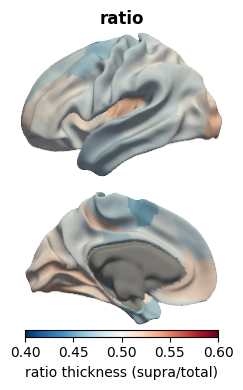

0
ratio
min: 0.400 max: 0.600
mean: nan ± nan


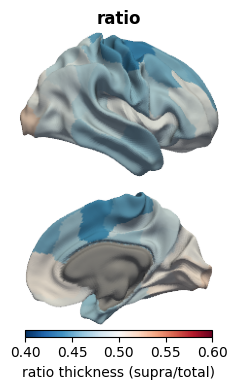

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Surface files and settings
lh_surf = '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.L.white_MSMAll.32k_fs_LR.surf.gii'
rh_surf = '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.R.white_MSMAll.32k_fs_LR.surf.gii'

data2plot = extra_parc100#either layer_data or layer_group_data
#data2plot = group_parc100
# Plot each hemisphere
for k in ['lh','rh']:
    fig, axes = plt.subplots(2, len(data2plot), figsize=(len(data2plot)*3, 4))
    
    surf = lh_surf if k=='lh' else rh_surf
    
    # Plot each layer
    
    for i, layer_name in enumerate(data2plot.keys()):
        print(i)
        print(layer_name)
        data = data2plot[layer_name][k]
        data_min = data[data != 0].min()
        data_max = data.max()
        cmap = 'jet'
        cbar_label = 'Thickness (mm)'
        
        if layer_name   ==  'relative':
            data_min = 0.8
            data_max = 1.2
            cmap = 'RbBu_r'
            cbar_label = 'Relative thickness (supra/infra)'
        elif layer_name == 'ratio':
            data_min = 0.4
            data_max = 0.6
            cmap = 'RdBu_r'
            cbar_label = 'ratio thickness (supra/total)'

        #before you do plotting, mask the subcortical areas
        # Create a copy of data to avoid modifying the original
        data_masked = data.copy()
        if k == 'lh':
            data_masked[atlas_schaefer400[0:32492] == 0] = np.nan
        else:
            data_masked[atlas_schaefer400[32492:] == 0] = np.nan
        data = data_masked
        
        
        print('min:', f'{data_min:.3f}', 'max:', f'{data_max:.3f}')
        norm = plt.Normalize(vmin=data_min, vmax=data_max)
        #calculate mean and std of data
        mean_data = data.mean()
        std_data = data.std()
        print('mean:', f'{mean_data:.3f}', '±', f'{std_data:.3f}')
        # Plot lateral and medial views
        for view_idx, view in enumerate(['lateral', 'medial']):
            plotter = yaspy.Plotter(surf, hemi=k)
            plotter.overlay(data, cmap=cmap, alpha=1, vmin=data_min, vmax=data_max)
            plotter.border(data, alpha=0)
            img = plotter.screenshot(view)

            if len(data2plot) == 1:
                axes[view_idx].imshow(img)
                axes[view_idx].axis('off')
            else:
                axes[view_idx,i].imshow(img)
                axes[view_idx,i].axis('off')
            
            if view_idx == 0:
                if len(data2plot) == 1:
                    axes[0].set_title(layer_name, fontweight='bold')
                else:   
                    axes[0,i].set_title(layer_name, fontweight='bold')
            else:
                if len(data2plot) == 1:
                    divider = make_axes_locatable(axes[1])
                else:
                    divider = make_axes_locatable(axes[1,i])
                cax = divider.append_axes("bottom", size="5%", pad=0.05)
                cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                           cax=cax, orientation='horizontal')
                cbar.set_label(cbar_label)

    plt.tight_layout()
    plt.show()


In [10]:

# Process left hemisphere data
lh_data_parc = {'total':[[] for _ in radii], 'infra':[[] for _ in radii], 'supra':[[] for _ in radii], 'relative':[[] for _ in radii], 'ratio':[[] for _ in radii]}


for i, radius in enumerate(radii):
    
    lh_data_parc['total'][i] = parcellate_data(lh_data['total'][i].T, atlas, 'lh').T
    lh_data_parc['infra'][i] = parcellate_data(lh_data['infra'][i].T, atlas, 'lh').T 
    lh_data_parc['supra'][i] = parcellate_data(lh_data['supra'][i].T, atlas, 'lh').T
    #lh_data_parc['relative'][i] = parcellate_data(lh_data['relative'][i].T, atlas_path, 'lh').T
    lh_data_parc['relative'][i] = lh_data_parc['supra'][i] / lh_data_parc['infra'][i]
    lh_data_parc['relative'][i][lh_data_parc['relative'][i] == np.inf] = 0
    lh_data_parc['relative'][i][lh_data_parc['relative'][i] == np.nan] = 0

    lh_data_parc['ratio'][i] = lh_data_parc['supra'][i] / lh_data_parc['total'][i]
    lh_data_parc['ratio'][i][lh_data_parc['ratio'][i] == np.inf] = 0
    lh_data_parc['ratio'][i][lh_data_parc['ratio'][i] == np.nan] = 0

    
# Process right hemisphere data  
rh_data_parc = {'total':[[] for _ in radii], 'infra':[[] for _ in radii], 'supra':[[] for _ in radii], 'relative':[[] for _ in radii], 'ratio':[[] for _ in radii]}

for i, radius in enumerate(radii):
    rh_data_parc['total'][i] = parcellate_data(rh_data['total'][i].T, atlas, 'rh').T
    rh_data_parc['infra'][i] = parcellate_data(rh_data['infra'][i].T, atlas, 'rh').T
    rh_data_parc['supra'][i] = parcellate_data(rh_data['supra'][i].T, atlas, 'rh').T
    #rh_data_parc['relative'][i] = parcellate_data(rh_data['relative'][i].T, atlas_path, 'rh').T
    rh_data_parc['relative'][i] = rh_data_parc['supra'][i] / rh_data_parc['infra'][i]
    rh_data_parc['relative'][i][rh_data_parc['relative'][i] == np.inf] = 0
    rh_data_parc['relative'][i][rh_data_parc['relative'][i] == np.nan] = 0

    rh_data_parc['ratio'][i] = rh_data_parc['supra'][i] / rh_data_parc['total'][i]
    rh_data_parc['ratio'][i][rh_data_parc['ratio'][i] == np.inf] = 0
    rh_data_parc['ratio'][i][rh_data_parc['ratio'][i] == np.nan] = 0


#plot the data

range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
range(0, 51)
[0, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
[0, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
[0, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 9

/var/folders/71/4g31r9017kq32wt_mx1khjdm0000gn/T/ipykernel_4772/3766046660.py:28: RuntimeWarning: invalid value encountered in divide
  rh_data_parc['relative'][i] = rh_data_parc['supra'][i] / rh_data_parc['infra'][i]
/var/folders/71/4g31r9017kq32wt_mx1khjdm0000gn/T/ipykernel_4772/3766046660.py:32: RuntimeWarning: invalid value encountered in divide
  rh_data_parc['ratio'][i] = rh_data_parc['supra'][i] / rh_data_parc['total'][i]


In [11]:
#layer type
layer_type = 'ratio_cleaned'#'predicted_x4'#, 'infra', 'supra', 'relative'

def process_hemisphere(data_parc, atlas_data, mask, surf_path, hemi):
    plotters_mean = []
    plotters_var = []
    
    # Calculate overall stats
    means = [np.nanmean(data_parc[layer_type][i][1:,:], axis=1) for i in range(len(radii))]
    vars = [np.var(data_parc[layer_type][i][1:,:], axis=1) for i in range(len(radii))]
    
    mean_surfaces = [map_to_labels(mean, atlas_data, mask=mask, fill=np.nan) for mean in means]
    var_surfaces = [map_to_labels(var, atlas_data, mask=mask, fill=np.nan) for var in vars]
    
    # Set visualization parameters based on layer type
    if layer_type == 'relative':
        vmin_mean = 0.8
        vmax_mean = 1.2
        cmap = 'RdBu_r'
        cbar_label = 'Relative thickness (supra/infra)'
    elif 'ratio' in layer_type:
        vmin_mean = 0.4
        vmax_mean = 0.6
        cmap = 'RdBu_r'
        cbar_label = 'ratio thickness (supra/total)'
    else:
        vmin_mean = np.nanmin([x for surf in mean_surfaces for x in surf if x != 0])
        vmax_mean = np.nanmax([x for surf in mean_surfaces for x in surf])
        cmap = 'jet'
        cbar_label = layer_type

    vmin_var = np.nanmin([x for surf in var_surfaces for x in surf if x != 0])
    vmax_var = np.nanmax([x for surf in var_surfaces for x in surf])

    # Generate plots
    for i in range(len(radii)):
        # Mean plotter
        plotter_mean = yaspy.Plotter(surf_path, hemi=hemi)
        overlay_mean = plotter_mean.overlay(mean_surfaces[i], cmap=cmap, alpha=1, 
                                         vmin=vmin_mean, vmax=vmax_mean)
        plotter_mean.border(mean_surfaces[i], alpha=0)
        plotters_mean.append([plotter_mean.screenshot("lateral"), 
                            plotter_mean.screenshot("medial"), 
                            overlay_mean])

        # Variance plotter  
        plotter_var = yaspy.Plotter(surf_path, hemi=hemi)
        overlay_var = plotter_var.overlay(var_surfaces[i], cmap='jet', alpha=1,
                                       vmin=vmin_var, vmax=vmax_var)
        plotter_var.border(var_surfaces[i], alpha=0)
        plotters_var.append([plotter_var.screenshot("lateral"),
                           plotter_var.screenshot("medial"),
                           overlay_var])
                           
    return plotters_mean, plotters_var

# Process hemispheres
mask_lh = atlas[:32492] != 0
mask_rh = atlas[32492:] != 0

lh_surf = '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.L.white_MSMAll.32k_fs_LR.surf.gii'
rh_surf = '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.R.white_MSMAll.32k_fs_LR.surf.gii'

plotters_lh_mean, plotters_lh_var = process_hemisphere(lh_data_parc, atlas[:32492], mask_lh, lh_surf, 'lh')
plotters_rh_mean, plotters_rh_var = process_hemisphere(rh_data_parc, atlas[32492:], mask_rh, rh_surf, 'rh')

# Create montages
def create_montage(plotters):
    return yaspy.montage([[p[0] for p in plotters], [p[1] for p in plotters]], 
                        pad=10, shareh=True, sharew=True)

img_lh_mean = create_montage(plotters_lh_mean)
img_rh_mean = create_montage(plotters_rh_mean) 
img_lh_var = create_montage(plotters_lh_var)
img_rh_var = create_montage(plotters_rh_var)

# Plot results
def plot_hemispheres(img_lh, img_rh, plotters_lh, plotters_rh, title, vmin=None, vmax=None):
    f, (ax1, ax2) = plt.subplots(1,2,figsize=(6,4))
    
    ax1.imshow(img_lh, vmin=vmin, vmax=vmax)
    
    ax1.axis('off')
    
    ax2.imshow(img_rh, vmin=vmin, vmax=vmax)
   
    ax2.axis('off')
    
    # Add colorbars
    for ax, plotters in [(ax1, plotters_lh), (ax2, plotters_rh)]:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("bottom", size="2.5%", pad=0.05)
        cbar = plt.colorbar(plotters[0][2], cax=cax, orientation="horizontal")
        #cbar.set_label(title)
    
    plt.tight_layout()
    plt.show()

plot_hemispheres(img_lh_mean, img_rh_mean, plotters_lh_mean, plotters_rh_mean, "Mean", vmin=0.4, vmax=0.7)
plot_hemispheres(img_lh_var, img_rh_var, plotters_lh_var, plotters_rh_var, "Variance", vmin=0.4, vmax=0.7)


KeyError: 'ratio_cleaned'

In [ ]:
total_corr_lh, infra_corr_lh, supra_corr_lh, relative_corr_lh, ratio_corr_lh = plot_subject_similarity(lh_data_parc, radii, partial_corr=True,shrink_it=False)  
total_corr_rh, infra_corr_rh, supra_corr_rh, relative_corr_rh, ratio_corr_rh = plot_subject_similarity(rh_data_parc, radii, partial_corr=True,shrink_it=False)

data2plot_lh = relative_corr_lh
data2plot_rh = relative_corr_rh

In [ ]:
data_len = 0
data_type ='infra_cleaned'
align_across_smooth = False
align_across_hemi = True
align_to_hcp = False
flip_sign_lh = False
flip_sign_rh = False
mask_index_lh = np.nan
mask_index_rh = np.nan

# Handle masking indices
#mask_index_lh = mask_index[:2] 
#mask_index_rh = mask_index[2:]-len(mask) 

print(f"Left hemisphere mask indices: {mask_index_lh}")
print(f"Right hemisphere mask indices: {mask_index_rh}")

data2plot_lh = eval(f"{data_type}_corr_lh")
data2plot_rh = eval(f"{data_type}_corr_rh")

N_components = 20
N_components_plot = 1

# Create hemisphere masks
atlasDat = atlas
mask_lh = atlasDat[:32492] != 0
mask_rh = atlasDat[32492:] != 0

def process_hemisphere(data2plot, mask_indices, atlas_data, hemisphere_mask, start_idx, end_idx):
    """Process gradient maps for one hemisphere"""
    gm_all = []
    grad_all = []
    
    for i, _ in enumerate(radii):
        # Fit gradient maps
        gm = GradientMaps(n_components=N_components, approach='dm', kernel='normalized_angle')
        
        if np.isnan(mask_indices).all():
            print('no mask')
            gm.fit(np.nan_to_num(data2plot[i], 0))
        else:
            mask = np.ones(data2plot[i].shape[0], dtype=bool)
            mask[mask_indices] = False
            gm.fit(data2plot[i])
        gm_all.append(gm)
        
        # Process gradients
        grad = []
        for j in range(N_components):
            data_len = len(data2plot[i])
            if np.isnan(mask_indices).all():
                tmp_gm = gm.gradients_[:,j]
            else:
               
                tmp_gm = np.full((data_len, 1), np.nan)
                tmp_gm[mask] = gm.gradients_[:,j].reshape(-1,1)
                tmp_gm = tmp_gm.ravel()
                
            atlas_slice = atlas_data[start_idx:end_idx]
            min_val = np.min(atlas_slice[atlas_slice != 0])
            max_val = np.max(atlas_slice[atlas_slice != 0])
            #print(f"Atlas range: {min_val}-{max_val}")
            grad.append(map_to_labels(tmp_gm, atlas_slice, mask=hemisphere_mask, 
                                    fill=np.nan, source_lab=np.arange(min_val,max_val+1)))
            
        grad_all.append(grad)
    
    return gm_all, grad_all

# Process both hemispheres
gm_all_lh, grad_all_lh = process_hemisphere(data2plot_lh, mask_index_lh, atlasDat, mask_lh, 0, 32492)
gm_all_rh, grad_all_rh = process_hemisphere(data2plot_rh, mask_index_rh, atlasDat, mask_rh, 32492, None)

def align_gradients_across_smooth(gm_all, data2plot, mask_indices, atlas_data, hemisphere_mask, start_idx, end_idx):
    """Align gradients for one hemisphere"""
    grad_all_aligned = []
    
    for i in range(len(gm_all)):
        tmp = gm_all[i].gradients_
        tmp_gm_aligned = ga.procrustes(tmp, gm_all[0].gradients_, center=True, scale=True)
        grad = []
        
        for j in range(N_components):
            data_len = len(data2plot[i])
            if np.isnan(mask_indices).all():
                tmp_gm = tmp_gm_aligned[:,j]
            else:
                mask = np.ones(data2plot[i].shape[0], dtype=bool)
                mask[mask_indices] = False
                tmp_gm = np.full((data_len, 1), np.nan)
                tmp_gm[mask] = tmp_gm_aligned[:,j].reshape(-1,1)
                tmp_gm = tmp_gm.ravel()
            
            atlas_slice = atlas_data[start_idx:end_idx]
            min_val = np.min(atlas_slice[atlas_slice != 0])
            max_val = np.max(atlas_slice[atlas_slice != 0])
            print(f"Atlas range: {min_val}-{max_val}")
            grad.append(map_to_labels(tmp_gm, atlas_slice, mask=hemisphere_mask,
                                    fill=np.nan, source_lab=np.arange(min_val,max_val+1)))
            
        grad_all_aligned.append(grad)
        
    return grad_all_aligned

# Align gradients across smotthing parameters (if exist) for each hemisphere
if align_across_smooth:
    grad_all_aligned_lh = align_gradients_across_smooth(gm_all_lh, data2plot_lh, mask_index_lh, atlasDat, mask_lh, 0, 32492)
    grad_all_aligned_rh = align_gradients_across_smooth(gm_all_rh, data2plot_rh, mask_index_rh, atlasDat, mask_rh, 32492, None)
else:
    grad_all_aligned_lh = grad_all_lh
    grad_all_aligned_rh = grad_all_rh

def align_gradients(gm_all_src, gm_all_trg, flip_sign=False):
    """Align source gradients to target gradients.
    
    Parameters
    ----------
    gm_all_src : list
        List of gradient mapping objects to be aligned
    gm_all_trg : list 
        List of target gradient mapping objects
        
    Returns
    -------
    gm_all_src : list
        List of aligned gradient mapping objects
    """
    if len(gm_all_src) != len(gm_all_trg):
        raise ValueError("Lists must be same length")
    
    for i, src in enumerate(gm_all_src):
        src.gradients_ = ga.procrustes(src.gradients_, gm_all_trg[i].gradients_, center=True, scale=True)
        if flip_sign:
            src.gradients_ = -src.gradients_
    
    return gm_all_src

def map_gradients(gm_all, data2plot, mask_indices, atlas_data, hemisphere_mask, start_idx, end_idx):
    """Map gradients to atlas data"""
    grad_all_aligned = []
    for i, gm in enumerate(gm_all):
        grad = []
        for j in range(N_components):
            # Get gradient data
            tmp_gm = gm.gradients_[:,j] if np.isnan(mask_indices).all() else \
                    np.full(len(data2plot[i]), np.nan)
            
            # Apply mask if needed
            if not np.isnan(mask_indices).all():
                mask = np.ones(data2plot[i].shape[0], dtype=bool)
                mask[mask_indices] = False
                tmp_gm[mask] = gm.gradients_[:,j]
            
            # Map to atlas labels
            atlas_slice = atlas_data[start_idx:end_idx]
            nonzero = atlas_slice[atlas_slice != 0]
            grad.append(map_to_labels(tmp_gm, atlas_slice, mask=hemisphere_mask,
                                    fill=np.nan, source_lab=np.arange(nonzero.min(), nonzero.max()+1)))
        grad_all_aligned.append(grad)
    return grad_all_aligned
     

#
gm_lh_aligned =gm_all_lh
gm_rh_aligned = gm_all_rh
grad_all_aligned_lh = grad_all_lh
grad_all_aligned_rh = grad_all_rh

if flip_sign_lh:
    gm_lh_aligned = align_gradients(gm_lh_aligned, gm_lh_aligned,flip_sign=True)
    grad_all_aligned_lh = map_gradients(gm_lh_aligned, data2plot_lh, mask_index_lh, atlasDat, mask_lh, 0, 32492)
    
if flip_sign_rh:
    gm_rh_aligned = align_gradients(gm_rh_aligned, gm_rh_aligned,flip_sign=True)
    grad_all_aligned_rh = map_gradients(gm_rh_aligned, data2plot_rh, mask_index_rh, atlasDat, mask_rh, 32492, None)


if align_across_hemi:
    gm_lh_aligned = gm_all_lh
    gm_rh_aligned = align_gradients(gm_all_rh, gm_all_lh)
    grad_all_aligned_lh = map_gradients(gm_lh_aligned, data2plot_lh, mask_index_lh, atlasDat, mask_lh, 0, 32492)
    grad_all_aligned_rh = map_gradients(gm_rh_aligned, data2plot_rh, mask_index_rh, atlasDat, mask_rh, 32492, None)


if align_to_hcp:
    gm_lh = [None]; gm_rh = [None]
    #these gm_lh_hcp_n{N}_{num_parcels}.npy are created in analysis_layer_hcp.ipynb
    gm_lh[0] = np.load(f'gm_lh_hcp_n300_p{num_parcels}_norm{normalize_data}.npy',allow_pickle=True)[()]
    gm_rh[0] = np.load(f'gm_rh_hcp_n300_p{num_parcels}_norm{normalize_data}.npy',allow_pickle=True)[()]
    gm_lh_aligned = align_gradients(gm_all_lh, gm_lh)
    gm_rh_aligned = align_gradients(gm_all_rh, gm_rh)
    grad_all_aligned_lh = map_gradients(gm_lh_aligned, data2plot_lh, mask_index_lh, atlasDat, mask_lh, 0, 32492)
    grad_all_aligned_rh = map_gradients(gm_rh_aligned, data2plot_rh, mask_index_rh, atlasDat, mask_rh, 32492, None)


def create_hemisphere_plots(grad_all_aligned, surf_file, hemi):
    """Create plots for one hemisphere"""
    plotters = []
    vmin = np.nanmin([grad_all_aligned[i][pc] for i in range(len(radii))])
    vmax = np.nanmax([grad_all_aligned[i][pc] for i in range(len(radii))])
    m = np.max(np.abs([vmin, vmax]))

    for i, _ in enumerate(radii):
        plotter = yaspy.Plotter(surf_file, hemi=hemi)
        overlay = plotter.overlay(grad_all_aligned[i][pc], cmap='RdBu_r', alpha=1, vmin=-m, vmax=m)
        plotter.border(grad_all_aligned[i][pc], alpha=0)
        plotters.append([plotter.screenshot("lateral"), plotter.screenshot("medial"), overlay])
        
    return plotters, m

# Plot gradients for each principal component
for pc in range(N_components_plot):
    # Create plots for both hemispheres
    plotters_lh, m_lh = create_hemisphere_plots(
        grad_all_aligned_lh,
        '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.L.white_MSMAll.32k_fs_LR.surf.gii',
        'lh'
    )
    
    plotters_rh, m_rh = create_hemisphere_plots(
        grad_all_aligned_rh,
        '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.R.white_MSMAll.32k_fs_LR.surf.gii',
        'rh'
    )

    # Create montages
    img_lh = yaspy.montage(
        [[plotters_lh[i][0] for i in range(len(radii))],
         [plotters_lh[i][1] for i in range(len(radii))]],
        pad=10, shareh=True, sharew=True,
    )
    
    img_rh = yaspy.montage(
        [[plotters_rh[i][0] for i in range(len(radii))],
         [plotters_rh[i][1] for i in range(len(radii))]],
        pad=10, shareh=True, sharew=True,
    )

    # Create final figure
    f, (ax1, ax2) = plt.subplots(2,1, figsize=(4,8))
    
    # Left hemisphere
    ax1.imshow(img_lh)
   # ax1.set_title('Left Hemisphere')
    ax1.axis('off')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("bottom", size="3%", pad=0.05)
    cbar = plt.colorbar(plotters_lh[0][2], cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize="small")
    
    # Right hemisphere
    ax2.imshow(img_rh)
    #ax2.set_title('Right Hemisphere')
    ax2.axis('off')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("bottom", size="3%", pad=0.05)
    cbar = plt.colorbar(plotters_rh[0][2], cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize="small")
    #cax2 = ax2.inset_axes((0.8, 0, 0.15, 0.03))
    #cbar2 = plt.colorbar(plotters_rh[0][2], cax=cax2, orientation="horizontal")
    #cbar2.ax.tick_params(labelsize="x-small")

    plt.tight_layout()
    plt.show()


# Remove NaN values before computing correlation
lh_data_4mask= grad_all_aligned_lh[0][0].ravel()
rh_data_4mask = grad_all_aligned_rh[0][0].ravel()
mask = ~np.isnan(lh_data_4mask) & ~np.isnan(rh_data_4mask)
print('similarity',np.corrcoef(lh_data_4mask[mask], rh_data_4mask[mask])[0,1])


In [ ]:
# Function to create eigenvalue plot
def plot_eigenvalues(gm_aligned, color='#2E86C1'):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(4,4))
    
    # Calculate and plot normalized eigenvalues 
    eigenvalues = gm_aligned[0].lambdas_/np.sum(gm_aligned[0].lambdas_)
    ax.plot(range(1,len(eigenvalues)+1), eigenvalues, 'o-', 
            color=color, linewidth=2, markersize=6)
    
    # Customize plot
    ax.set_xlabel('Component', fontsize=18)
    ax.set_ylabel('Variance explained', fontsize=18)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xlim(0, len(eigenvalues))
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
    ax.tick_params(axis='both', which='major', labelsize=20)  # Increase tick label size
    
    plt.tight_layout()
    return fig, ax

# Create plots for left and right hemispheres
fig_lh, ax_lh = plot_eigenvalues(gm_lh_aligned, color='#E74C3C')
fig_rh, ax_rh = plot_eigenvalues(gm_rh_aligned, color='#E74C3C')

plt.show()



In [ ]:
# Create scatter plot with marginal histograms comparing cortical thickness to gradient values
import seaborn as sns
from scipy import stats

# Set up plot style
sns.set_style("white")
sns.set_context("notebook", font_scale=1.3)

# Create main figure
fig = plt.figure(figsize=(18, 6))
hemi = 'lh' # Choose hemisphere to plot

# Get data for selected hemisphere
if hemi == 'lh':
    thickness = np.mean(lh_data_parc[data_type][0][1:,:], axis=1)
    gradient = gm_lh_aligned[0].gradients_[:,0] 
else:
    thickness = np.mean(rh_data_parc[data_type][0][1:,:], axis=1)
    gradient = gm_rh_aligned[0].gradients_[:,0]

# Calculate correlation (excluding NaN values)
mask = ~np.isnan(thickness) & ~np.isnan(gradient)
r, p = stats.pearsonr(thickness[mask], gradient[mask])
print(r,p)

# Set up subplot grid
gs = fig.add_gridspec(3, 3, hspace=0.2, wspace=0.2, left=0.05, right=0.32)

# Create main scatter plot
ax_scatter = fig.add_subplot(gs[1:, :-1])
sns.scatterplot(x=thickness, y=gradient, alpha=0.6, s=40, color='#8E44AD',
                edgecolor='white', linewidth=0.5, ax=ax_scatter)
sns.regplot(x=thickness, y=gradient, scatter=False, color='black',
            line_kws={'linestyle': '-', 'linewidth': 1.5}, ax=ax_scatter)

# Add correlation stats
ax_scatter.text(0.05, 0.95, f'r = {r:.2f}\np = {p:.2e}',
                transform=ax_scatter.transAxes,
                verticalalignment='top', fontsize=14)

# Label axes
if data_type == 'ratio':
    ax_scatter.set_ylabel('Supra/Total Ratio', fontsize=14, labelpad=10, weight='bold')
else:
    ax_scatter.set_ylabel('G1', fontsize=14, labelpad=10, weight='bold')
    ax_scatter.set_xlabel('Cortical Thickness (mm)', fontsize=14, labelpad=10, weight='bold')

ax_scatter.grid(True, linestyle='--', alpha=0.2)

# Add marginal histograms
# Top histogram (x-axis)
ax_histx = fig.add_subplot(gs[0, :-1])
sns.histplot(data=thickness, bins=50, kde=True, color='#8E44AD',
             ax=ax_histx, stat='density', alpha=0.7)
ax_histx.set(xlabel='', ylabel='')
ax_histx.set_yticks([])
ax_histx.tick_params(labelbottom=False)
for spine in ax_histx.spines.values():
    spine.set_visible(False)

# Right histogram (y-axis) 
ax_histy = fig.add_subplot(gs[1:, -1])
sns.histplot(y=np.flip(gradient), bins=50, kde=True, color='#8E44AD',
             ax=ax_histy, stat='density', alpha=0.7)
ax_histy.set(xlabel='', ylabel='')
ax_histy.set_xticks([])
ax_histy.tick_params(labelleft=False)
for spine in ax_histy.spines.values():
    spine.set_visible(False)

plt.tight_layout()


In [ ]:
import os
import numpy as np
import nibabel as nib
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import yaspy
# Load and process BigBrain layer data
big_brain_layer_dir = '/Users/dennis.jungchildmind.org/Downloads/BigBrain/thickness/resample/'
#supra_sample = lh_data['supra'][0]
#infra_sample = lh_data['infra'][0]
#total_sample = supra_sample+infra_sample#lh_data['total'][0]#this total is little different from the supra_sample + infra_sample

def load_layers_bb(hemi):
    """Load each layer thickness data for a given hemisphere"""
    layers = {}
    for layer in range(1,7):
        start = layer-1
        filename = f'{hemi}.{start}-{layer}.32k.shape.gii'
        layers[f'L{layer}'] = nib.load(os.path.join(big_brain_layer_dir, filename)).darrays[0].data
    return np.stack([layers[f'L{layer}'] for layer in range(1,7)], axis=1)

# Load data for both hemispheres
bb_layers_lh = load_layers_bb('lh')
bb_layers_rh = load_layers_bb('rh')

print(f"BigBrain layer data shape: {bb_layers_lh.shape}")

# Prepare template data (BigBrain data) for regression analysis
def prepare_template_data(layer_data, target_layer):
    """Prepare template data for regression"""
    supra = np.sum(layer_data[:,0:3], axis=1)#as defined in the ex vivo data (L1-3)
    infra = np.sum(layer_data[:,3:], axis=1)#as defined in the ex vivo data (L4-6) * 
    total = np.sum(layer_data, axis=1)
    vertex_id = np.arange(layer_data.shape[0])#positional information
    x = np.column_stack([supra,infra, vertex_id])
    y = layer_data[:,target_layer]  # Layer 4 * we want to regress out layer 4 from the infragranular (L4-6 in ex vivo)
    return x, y

#BigBrain data as template data for the model fitting
#perform for each layer and hemisphere
r2_all = {'lh': [], 'rh': []}
mse_all = {'lh': [], 'rh': []}
mlr_models = {'lh': [], 'rh': []}
bb_layers = {'lh': bb_layers_lh, 'rh': bb_layers_rh}

  
for hemi in ['lh', 'rh']:
    for layer in range(0,6):
        x_template, y_template = prepare_template_data(bb_layers[hemi],[layer])

        # Fit multiple linear regression model
        mlr_model = LinearRegression(fit_intercept=True,tol=1e-6,copy_X=True)
        #mlr_model = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=10)
        #mlr_model = RandomForestRegressor(n_estimators=100, random_state=42)
        mlr_model.fit(x_template, y_template)
        y_pred = mlr_model.predict(x_template)
        
        # Calculate and store metrics
        r2_all[hemi].append(r2_score(y_template, y_pred))
        mse_all[hemi].append(mean_squared_error(y_template, y_pred))
        mlr_models[hemi].append(mlr_model)
        print(f'{hemi.upper()} Model performance - R2: {r2_all[hemi][-1]:.3f}, MSE: {mse_all[hemi][-1]:.3f}')
#plt.plot(y_template,y_pred,'.')

plt.figure(figsize=(5,4))
x = np.arange(6)
width = 0.35
plt.bar(x - width/2, r2_all['lh'], width, label='LH', color='#2ecc71')  # Emerald green
plt.bar(x + width/2, r2_all['rh'], width, label='RH', color='#3498db')  # Bright blue
plt.xticks(x, ['L1', 'L2', 'L3', 'L4', 'L5', 'L6'])

plt.ylim(0, 1)
plt.ylabel('R² Score')
plt.xlabel('Cortical Layer')
plt.title('MLR Performance')
plt.legend(loc='lower left', framealpha=1.0)
plt.tight_layout()
plt.show()

In [ ]:
#based on the previous section, let's calculate infra_cleaned with multiple linear regression
mlr_model_lh = LinearRegression(fit_intercept=True,tol=1e-6,copy_X=True)
#mlr_model_lh = RandomForestRegressor(n_estimators=100, random_state=42)
x_template_lh, y_template_lh = prepare_template_data(bb_layers_lh,3)
mlr_model_lh.fit(x_template_lh, y_template_lh)
y_pred_lh = mlr_model_lh.predict(x_template_lh)
print('r2_score',r2_score(y_template_lh, y_pred_lh))
print('mean_squared_error',mean_squared_error(y_template_lh, y_pred_lh))

mlr_model_rh = LinearRegression(fit_intercept=True,tol=1e-6,copy_X=True)
#mlr_model_rh = RandomForestRegressor(n_estimators=100, random_state=42)
x_template_rh, y_template_rh = prepare_template_data(bb_layers_rh,3)
mlr_model_rh.fit(x_template_rh, y_template_rh)
y_pred_rh = mlr_model_rh.predict(x_template_rh)
print('r2_score',r2_score(y_template_rh, y_pred_rh))
print('mean_squared_error',mean_squared_error(y_template_rh, y_pred_rh))


# Process samples
def process_samples(mlr_model,supra_sample, infra_sample):
    """Process all samples to remove layer 4 contribution"""
    n_vertices, n_samples = supra_sample.shape
    predicted_x4 = np.zeros((n_vertices, n_samples))
    infra_cleaned = np.zeros((n_vertices, n_samples))
    vertex_id = np.arange(n_vertices)

    for i in range(n_samples):
        X = np.column_stack([supra_sample[:,i], infra_sample[:,i],vertex_id])
        
        pred_layers = mlr_model.predict(X)
        
        predicted_x4[:,i] = pred_layers#np.sum(pred_layers,axis=1)
        
        infra_cleaned[:,i]= infra_sample[:,i] - predicted_x4[:,i]
        
        print(f"Sample {i+1}: Layer 4 range [{predicted_x4.min():.3f}, {predicted_x4.max():.3f}]")
        
    return predicted_x4, infra_cleaned


supra_sample_lh = lh_data['supra'][0]
infra_sample_lh = lh_data['infra'][0]
supra_sample_rh = rh_data['supra'][0]
infra_sample_rh = rh_data['infra'][0]
predicted_x4_lh, infra_cleaned_lh = process_samples(mlr_model_lh,supra_sample_lh, infra_sample_lh)
predicted_x4_rh, infra_cleaned_rh = process_samples(mlr_model_rh,supra_sample_rh, infra_sample_rh)



In [ ]:

total_sample_lh = lh_data['total'][0]
total_sample_rh = rh_data['total'][0]

ratio_cleaned_lh = infra_cleaned_lh / total_sample_lh
ratio_cleaned_rh = infra_cleaned_rh / total_sample_rh


# Calculate and plot cleaned data
#cleaned_data_lh = np.mean(infra_cleaned_lh, axis=1)
#cleaned_data_rh = np.mean(infra_cleaned_rh, axis=1)

data2plot_lh = np.mean(ratio_cleaned_lh, axis=1) 
data2plot_rh = np.mean(ratio_cleaned_rh, axis=1)

#data2plot_lh = np.mean(infra_cleaned_lh, axis=1)
#data2plot_rh = np.mean(infra_cleaned_rh, axis=1)

cmap = 'RdBu_r'

#data2plot = np.mean(predicted_x4,axis=1)

# Visualization
surf_path = '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.R.white_MSMAll.32k_fs_LR.surf.gii'
plotter = yaspy.Plotter(surf_path, hemi='rh')
overlay = plotter.overlay(data2plot_rh, cmap=cmap, alpha=1,vmin=0.4,vmax=0.6)
plotter.border(data2plot_rh, alpha=0)

# Create and display figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,4))
ax1.imshow(plotter.screenshot("lateral"))
ax1.axis('off')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("bottom", size="3%", pad=0.05)
cbar = plt.colorbar(overlay, cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize="small")

ax2.imshow(plotter.screenshot("medial"))
ax2.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
#lh_data_parc['total'][i] = parcellate_data(lh_data['total'][i].T, atlas, 'lh').T
#lh_data_parc['total'][i] = parcellate_data(lh_data['total'][i].T, atlas, 'lh').T
lh_data_parc['infra_cleaned'] = {}
rh_data_parc['infra_cleaned'] = {}

lh_data_parc['infra_cleaned'][0] = parcellate_data(infra_cleaned_lh.T, atlas, 'lh').T
rh_data_parc['infra_cleaned'][0] = parcellate_data(infra_cleaned_rh.T, atlas, 'rh').T

infra_cleaned_corr_lh = {0: calculate_correlation_matrix(lh_data_parc['infra_cleaned'][0], transpose=False, partial_corr=True, shrink_it=False, first_index=1)}
infra_cleaned_corr_rh = {0: calculate_correlation_matrix(rh_data_parc['infra_cleaned'][0], transpose=False, partial_corr=True, shrink_it=False, first_index=1)}
print(infra_cleaned_corr_lh[0].shape)
print(infra_cleaned_corr_rh[0].shape)

lh_data_parc['ratio_cleaned'] = {}
rh_data_parc['ratio_cleaned'] = {}
lh_data_parc['ratio_cleaned'][0] = parcellate_data(infra_cleaned_lh.T/total_sample_lh.T, atlas, 'lh').T
rh_data_parc['ratio_cleaned'][0] = parcellate_data(infra_cleaned_rh.T/total_sample_rh.T, atlas, 'rh').T

ratio_cleaned_corr_lh = {0: calculate_correlation_matrix(lh_data_parc['ratio_cleaned'][0], transpose=False, partial_corr=True, shrink_it=False, first_index=1)}
ratio_cleaned_corr_rh = {0: calculate_correlation_matrix(rh_data_parc['ratio_cleaned'][0], transpose=False, partial_corr=True, shrink_it=False, first_index=1)}
print(ratio_cleaned_corr_lh[0].shape)
print(ratio_cleaned_corr_rh[0].shape)

lh_data_parc['predicted_x4'] = {}
rh_data_parc['predicted_x4'] = {}
lh_data_parc['predicted_x4'][0] = parcellate_data(predicted_x4_lh.T, atlas, 'lh').T
rh_data_parc['predicted_x4'][0] = parcellate_data(predicted_x4_rh.T, atlas, 'rh').T

predicted_x4_corr_lh = {0: calculate_correlation_matrix(lh_data_parc['predicted_x4'][0], transpose=False, partial_corr=True, shrink_it=False, first_index=1)}
predicted_x4_corr_rh = {0: calculate_correlation_matrix(rh_data_parc['predicted_x4'][0], transpose=False, partial_corr=True, shrink_it=False, first_index=1)}
print(predicted_x4_corr_lh[0].shape)
print(predicted_x4_corr_rh[0].shape)







